In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import masks

## General

In [2]:
lmax = 4096
#NSIDE = 2048
NSIDE = 256
NSIDE_gaia = NSIDE
NPIX = hp.nside2npix(NSIDE)
percentile_max = 95

In [3]:
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)
area_all = area_per_pixel*NPIX

In [4]:
rng = default_rng(seed=42)

## Load in Planck data

Data from https://pla.esac.esa.int/#cosmology, (cosmology tab then lensing tab)

Details: https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing

In [5]:
fn_lensing = '../data/COM_Lensing_4096_R3.00/MV/dat_klm.fits'

Guidance here from: https://zonca.dev/2020/09/planck-spectra-healpy.html

In [6]:
alm_lensing = hp.read_alm(fn_lensing)

In [7]:
map_lensing = hp.alm2map(alm_lensing, nside=NSIDE, lmax=lmax)

In [8]:
fn_mask = '../data/COM_Lensing_4096_R3.00/mask.fits.gz'
mask_planck = hp.read_map(fn_mask, dtype=bool)
print(hp.npix2nside(len(mask_planck)))
mask_planck = hp.pixelfunc.ud_grade(mask_planck, NSIDE)
print(hp.npix2nside(len(mask_planck)))

2048
256


In [9]:
aposize_deg = 0.5 #30' (arcmin)
mask_apod = nmt.mask_apodization(mask_planck, aposize_deg, apotype="C2")

In [10]:
map_lensing_masked = hp.ma(map_lensing)
map_lensing_masked.mask = np.logical_not(mask_apod)

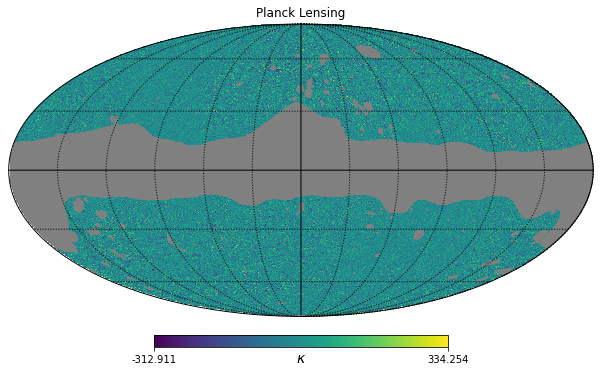

In [11]:
hp.mollview(map_lensing_masked, title=rf"Planck Lensing", unit=r"$\kappa$",
            cmap='viridis', #coord=['C', 'G']
)
hp.graticule()

In [12]:
# can't figure out how to set lmin! but this fixes the scaling
# should i mask and then smooth or vice versa??
map_lensing_smooth = hp.smoothing(map_lensing_masked, lmax=1000)

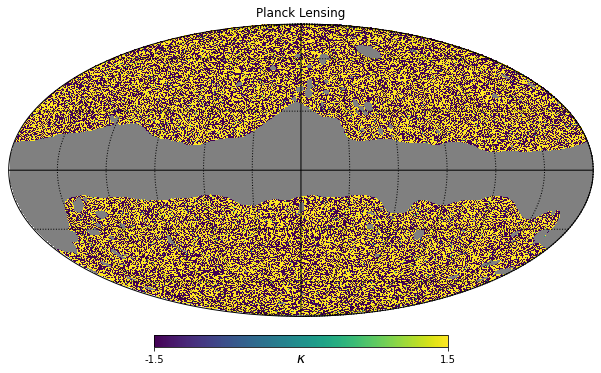

In [13]:
a

## Gaia quasars

The sample that has speczs is our cleaner sample of G<20 and QSO color cuts (even though we don't need the z's for now)

In [14]:
# things are weird for quasars at high nside - zeros! so just trying this for now
NPIX_gaia = hp.nside2npix(NSIDE_gaia)
print("NPIX gaia:", NPIX_gaia)

NPIX gaia: 786432


In [15]:
G_max = 20
fn_gaia = f'../data/gaia_G{G_max}.fits'
tab_gaia = utils.load_table(fn_gaia)
print('Number of Gaia quasars:', len(tab_gaia))

Number of Gaia quasars: 648842


In [16]:
ra_gaia_all = tab_gaia['ra']
dec_gaia_all = tab_gaia['dec']

In [17]:
NSIDE_gaia

256

In [18]:
len(ra_gaia_all)

648842

In [19]:
map_nqso_gaia_all, pixel_indices = utils.get_map(NSIDE_gaia, ra_gaia_all, dec_gaia_all, null_val=0)

In [20]:
np.min(map_nqso_gaia_all), np.max(map_nqso_gaia_all)

(0, 9)

In [21]:
len(map_nqso_gaia_all)

786432

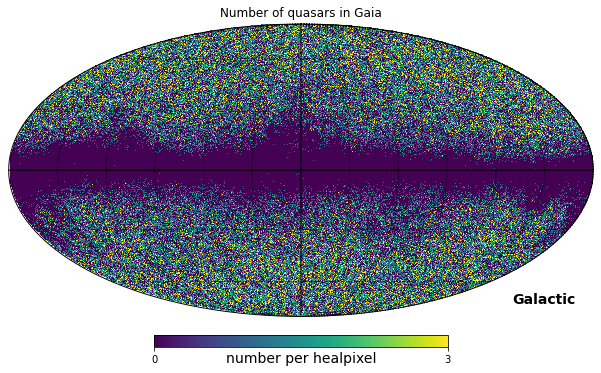

In [22]:
hp.mollview(map_nqso_gaia_all, title=rf"Number of quasars in Gaia",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], 
            min=0, max=np.percentile(map_nqso_gaia_all, percentile_max))
hp.graticule()

### Load randoms

In [23]:
fn_rand = f'../data/randoms/random_stardustm1064_G{G_max}_10x.fits'
tab_rand = utils.load_table(fn_rand)

In [24]:
ra_rand_all = tab_rand['ra']
dec_rand_all = tab_rand['dec']

In [25]:
map_nqso_rand_all, _ = utils.get_map(NSIDE_gaia, ra_rand_all, dec_rand_all, null_val=0)

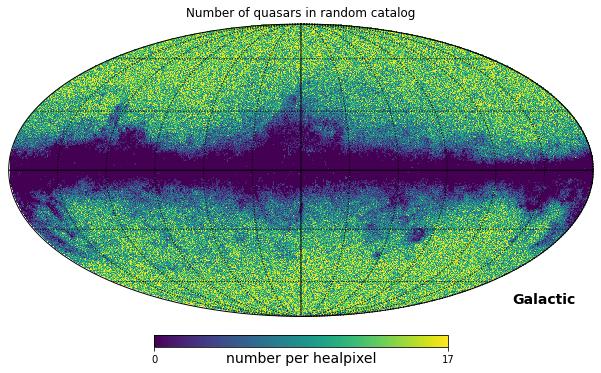

In [26]:
hp.mollview(map_nqso_rand_all, title=rf"Number of quasars in random catalog",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], 
            min=0, max=np.percentile(map_nqso_rand_all, percentile_max))
hp.graticule()

## Apply masks to both data and randoms

In [27]:
b_max = 10
Av_max = 0.2
R = 3.1

mask_names_to_include = ['plane', 'mcs', 'dust']
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
# dict points to tuple with masks and extra args
mask_gaia_dict = {'plane': (masks.galactic_plane_mask, [b_max]),
                  'mcs': (masks.magellanic_clouds_mask, []),
                  'dust': (masks.galactic_dust_mask, [Av_max, R, fn_dustmap])}

In [28]:
for mask_name in mask_names_to_include:
    mask_func, mask_func_args = mask_gaia_dict[mask_name]
    idx_keep_gaia = masks.subsample_by_mask(NSIDE_gaia, ra_gaia_all, dec_gaia_all, mask_func, mask_func_args)
    ra_gaia, dec_gaia = ra_gaia_all[idx_keep_gaia], dec_gaia_all[idx_keep_gaia]
    idx_keep_rand = masks.subsample_by_mask(NSIDE_gaia, ra_rand_all, dec_rand_all, mask_func, mask_func_args)
    ra_rand, dec_rand = ra_rand_all[idx_keep_rand], dec_rand_all[idx_keep_rand]

Applied mask, kept 0.988 of sources
Applied mask, kept 0.984 of sources
Applied mask, kept 0.997 of sources
Applied mask, kept 0.998 of sources
256 3.1 ../data/maps/map_dust_NSIDE256.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE256.npy
Applied mask, kept 0.710 of sources
256 3.1 ../data/maps/map_dust_NSIDE256.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE256.npy
Applied mask, kept 0.700 of sources


In [29]:
map_nqso_gaia, pixel_indices = utils.get_map(NSIDE_gaia, ra_gaia, dec_gaia, null_val=0)

In [30]:
map_nqso_rand, pixel_indices_rand = utils.get_map(NSIDE_gaia, ra_rand, dec_rand, null_val=0)

### Plot maps

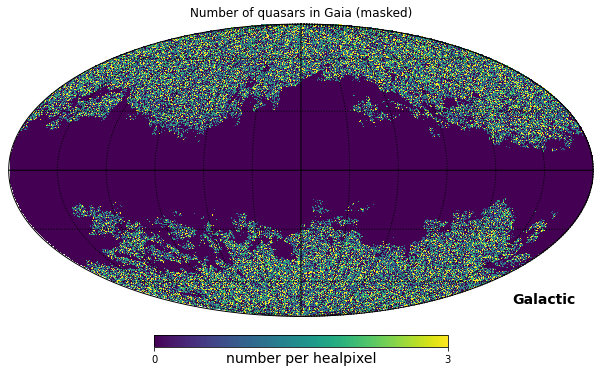

In [31]:
hp.mollview(map_nqso_gaia, title=rf"Number of quasars in Gaia (masked)",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], 
            min=0, max=np.percentile(map_nqso_gaia_all, percentile_max))
hp.graticule()

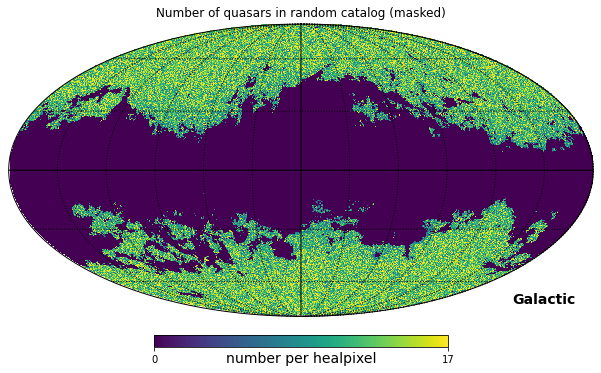

In [32]:
hp.mollview(map_nqso_rand, title=rf"Number of quasars in random catalog (masked)",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], 
            min=0, max=np.percentile(map_nqso_rand, percentile_max))
hp.graticule()

## Construct overdensity map

"The weighted random counts in each Healpix pixel then form the “random map”. The overdensity field is defined as the “LRG map” divided by the “random map”, normalized to mean density and mean subtracted." (White 2022)

TODO: figure out what to do about these zeros!

In [33]:
map_overdensity = map_nqso_gaia / map_nqso_rand
idx_odens_finite = np.isfinite(map_overdensity)
map_overdensity /= np.mean(map_overdensity[idx_odens_finite]) #?? is this what normalized to mean density means?
map_overdensity -= np.mean(map_overdensity[idx_odens_finite])

/state/partition1/job-22979060/ipykernel_2497816/91174296.py:1: RuntimeWarning: divide by zero encountered in true_divide
  map_overdensity = map_nqso_gaia / map_nqso_rand
/state/partition1/job-22979060/ipykernel_2497816/91174296.py:1: RuntimeWarning: invalid value encountered in true_divide
  map_overdensity = map_nqso_gaia / map_nqso_rand


In [34]:
map_overdensity[~idx_odens_finite] = hp.UNSEEN

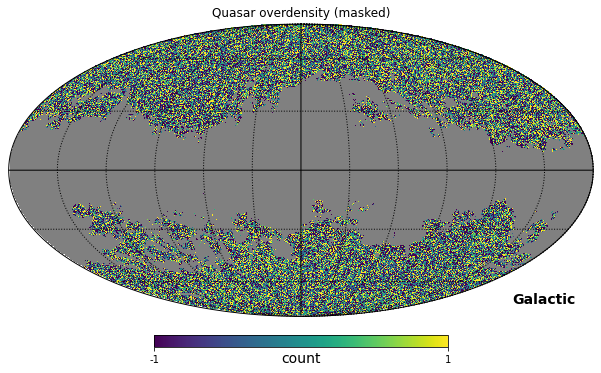

In [35]:
hp.mollview(map_overdensity, title=rf"Quasar overdensity (masked)",
    unit=r"count", cmap='viridis', coord=['C', 'G'], min=-1, max=1)
hp.graticule()

## Compute pseudo-Cls

Following https://arxiv.org/pdf/2111.09898.pdf and https://namaster.readthedocs.io/en/latest/sample_simple.html

In [36]:
field_planck = nmt.NmtField(mask_apod, [map_lensing_smooth], lite=True)

In [37]:
masks_gaia = np.zeros(NPIX_gaia)
field_gaia = nmt.NmtField(masks_gaia, [map_overdensity], lite=True)

"We choose a conservative binning scheme with linearly spaced bins of
size ∆l = 50 starting from l_min = 25."

I tested max of 600 vs 6000; not much different up to 600

In [38]:
# Initialize binning scheme with 4 ells per bandpower
#b = nmt.NmtBin.from_nside_linear(nside, 4)
ell_min = 25
ell_max = 600
ell_bin_width = 50
ell_edges = np.arange(ell_min, ell_max+ell_bin_width, ell_bin_width)
ell_ini = ell_edges[:-1]
ell_end = ell_edges[1:]
b = nmt.NmtBin.from_edges(ell_ini, ell_end)

In [39]:
# Compute MASTER estimator
cl_planck_gaia = nmt.compute_full_master(field_planck, field_gaia, b)

RuntimeError: No deprojection bias for lightweight fields!


In [ ]:
cl_gaia_gaia = nmt.compute_full_master(field_gaia, field_gaia, b)

In [ ]:
mult_fac = 1e6

In [ ]:
ell_arr = b.get_effective_ells()
ell_arr_cut = b_cut.get_effective_ells()
plt.plot(ell_arr, mult_fac*cl_planck_gaia[0], 'r-', label=r'$\kappa q$')
plt.plot(ell_arr, mult_fac*cl_gaia_gaia[0], 'r-', label=r'$q q$')
plt.yscale('log')
plt.xlim(0, 600)
plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
# # Initialize binning scheme with 4 ells per bandpower
# #b = nmt.NmtBin.from_nside_linear(nside, 4)
# ell_min_log = 1
# ell_max_log = 3
# n_ell_bins_log = 20
# ell_edges_log = np.array(np.round(np.logspace(ell_min_log, ell_max_log, n_ell_bins_log)), dtype=int)
# ell_ini_log = ell_edges_log[:-1]
# ell_end_log = ell_edges_log[1:]
# b_log = nmt.NmtBin.from_edges(ell_ini_log, ell_end_log)

In [ ]:
# Compute MASTER estimator
# cl_00_log = nmt.compute_full_master(field, field, b_log)

In [ ]:
# ell_arr_log = b_log.get_effective_ells()
# prefac = ell_arr_log*(ell_arr_log+1)/(2*np.pi)
# plt.plot(ell_arr_log, prefac*cl_00_log[0], 'b-', label=r'$\kappa \kappa$ (lmax cut)')
# plt.xscale('log')
# #plt.xlim(0, 600)
# #plt.ylim(1e-1, 1e1)
# plt.xlabel('$\\ell$', fontsize=16)
# plt.ylabel(r'$\ell(\ell+1) \, C_\ell \, / \, (2\pi)$', fontsize=16)
# plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
# plt.show()